In [67]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from unidecode import unidecode
import missingno as msno

from imblearn.over_sampling import SMOTE
import joblib

from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import (train_test_split, RandomizedSearchCV)
from sklearn.metrics import (accuracy_score, precision_score,
                             recall_score, f1_score, roc_curve, auc, roc_auc_score)
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, VotingClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.impute import KNNImputer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
from sklearn.model_selection import KFold
from scipy import stats
import numpy as np
import pandas as pd

from sklearn.feature_selection import mutual_info_classif

from xgboost import XGBClassifier

import eli5
from eli5.sklearn import PermutationImportance
from lime.lime_tabular import LimeTabularExplainer

import warnings
from sklearn.exceptions import UndefinedMetricWarning


pd.plotting.register_matplotlib_converters()
%matplotlib inline

%load_ext autoreload
%autoreload 2
from help_tool import help_tool


"""Setting graph parameters"""
sns.set_theme(style='whitegrid')
sns.set_palette('husl')


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
amenities = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
continuous_features = ['Age', 'Group', 'Deck_num'] + amenities
category_features = ['HomePlanet', 'Destination', 'Deck', 'Group_Id']
binary_features = ['CryoSleep', 'VIP', 'Transported']

In [3]:
train = help_tool.csv_download(r'Archive\spaceship-titanic\train.csv')
help_tool.first_look(train)

Dataset has 8693 observations and 14 features
Columns with all empty values []
Dataset has 0 duplicates


,dtypes,"Null values, Count","Null values, %"
PassengerId,object,0,0.0
HomePlanet,object,201,2.3
CryoSleep,object,217,2.5
Cabin,object,199,2.3
Destination,object,182,2.1
Age,float64,179,2.1
VIP,object,203,2.3
RoomService,float64,181,2.1
FoodCourt,float64,183,2.1
ShoppingMall,float64,208,2.4


In [4]:
test = help_tool.csv_download(r'Archive\spaceship-titanic\test.csv')
help_tool.first_look(test)

Dataset has 4277 observations and 13 features
Columns with all empty values []
Dataset has 0 duplicates


,dtypes,"Null values, Count","Null values, %"
PassengerId,object,0,0.0
HomePlanet,object,87,2.0
CryoSleep,object,93,2.2
Cabin,object,100,2.3
Destination,object,92,2.2
Age,float64,91,2.1
VIP,object,93,2.2
RoomService,float64,82,1.9
FoodCourt,float64,106,2.5
ShoppingMall,float64,98,2.3


In [5]:
avg_amenities = ['Avg_RoomService', 'Avg_FoodCourt', 'Avg_ShoppingMall',
       'Avg_Spa', 'Avg_VRDeck']
amenities = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

In [6]:
def missing_locations(df, feature):
    """ Assuming people from the same Sroup and Last_Name stick together. """
    df.sort_values(['Last_Name', 'Group', feature], inplace=True)
    groups = df.groupby(['Last_Name', 'Group'])
    
    for (last_name, group), group_df in groups:
        feature_finding = group_df[feature].dropna().iloc[0] if not group_df[feature].isnull().all() else None
        
        mask = (df['Last_Name'] == last_name) & (df['Group'] == group)
        df.loc[mask, feature] = feature_finding
    
    df.reset_index(drop=True, inplace=True)
    
    return df


In [7]:
def family(df):
    """ Creating GroupSize feature. """
    df['GroupSize'] = df.groupby(['Group', 'Last_Name'])['Group'].transform('size')
 
    return df

In [8]:
def planet_encoding(df):
    """ Encoding HomePlanet and Destination, sorted by distance from Earth. """
    df.loc[df['HomePlanet'] == 'Earth', 'HomePlanet_Encoded'] = 1
    df.loc[df['HomePlanet'] == 'Mars', 'HomePlanet_Encoded'] = 2
    df.loc[df['HomePlanet'] == 'Europa', 'HomePlanet_Encoded'] = 3

    df.loc[df['Destination'] == 'TRAPPIST-1e', 'Destination_Encoded'] = 1
    df.loc[df['Destination'] == '55 Cancri e', 'Destination_Encoded'] = 2
    df.loc[df['Destination'] == 'PSO J318.5-22', 'Destination_Encoded'] = 3

    return df

In [9]:
def empty_values(df):
    """ Filling in missing values with mode and mean. """
    # Fill in mode for missing categorical values
    for feature in ['CryoSleep', 'VIP', 'HomePlanet_Encoded', 
                    #'Transported', 
                    'Deck', 'Side', 'GroupSize', 'HomePlanet_Encoded', 'Destination_Encoded']:
        try:
            df[feature] = df[feature].astype(int)
        except: 
            df[feature] = df[feature].astype(float)

        df[feature].fillna(df[feature].mode()[0], inplace=True)

    # Fill in mode for missing continues values
    for feature in ['Age', 'Deck_num'] + amenities + avg_amenities:
        try:
            df[feature] = df[feature].astype(int)
        except: 
            df[feature] = df[feature].astype(float)
        df[feature].fillna(df[feature].mean(), inplace=True)

    return df

In [10]:
def cleaning(df):
    """ Performning data cleanign. """

    # PassengerId
    # Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group.
    df[['Group', 'Group_Id']] = df['PassengerId'].str.split('_', expand=True)

    # Name
    # Separating last name for family identifications
    df[['First_Name', 'Last_Name']] = df['Name'].str.split(' ', expand=True)


    # Cabin
    help_tool.cabin_split(df)


    # Missing locations
    df.loc[df['HomePlanet'].isna() & (df['Deck'] < 4), 'HomePlanet'] = 'Europa'
    df.loc[df['HomePlanet'].isna() & (df['Deck'] == 7), 'HomePlanet'] = 'Earth'

    for i in ['HomePlanet', 'Cabin', 'Destination']:
        df = missing_locations(df, i)

    # Cabin
    help_tool.cabin_split(df)


    # Amenities

    # CryoSleep: sleeping passangers have no expences
    # Age < 13: Passangers < 13 have no expences
    condition = (df['CryoSleep'] == 1) | (df['Age'] < 13)
    df.loc[condition, amenities] = df.loc[condition, amenities].fillna(0) 

    # Amenities log transformation
    # Updating spent amount to +1, when spent was 0 (for log transformation to work)
    #df[amenities] = np.log1p(df[amenities])
    #df['amenities'] = (df['amenities'] != 0).astype(int)
    #df['Amenities'] = df[amenities].sum(axis=1)

    # GroupSize column
    df['GroupSize'] = df.groupby(['Group', 'Last_Name'])['Group'].transform('size')

    for feature in amenities:
        df[f'Avg_{feature}'] = df.groupby(['Group', 'GroupSize'])[feature].transform('mean')

    # Location encoding
    planet_encoding(df)

    # Filling in rest of empty values with mode and mean
    empty_values(df)



    drop_features = ['PassengerId', 'Name', 'Cabin', 'First_Name', 'Last_Name', 'Group', 'Group_Id', 'HomePlanet', 'Destination', 'Deck']
    df.drop(columns=drop_features, inplace=True)
    
    return df

In [11]:
train = cleaning(train)
train.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck_num,Side,GroupSize,Avg_RoomService,Avg_FoodCourt,Avg_ShoppingMall,Avg_Spa,Avg_VRDeck,HomePlanet_Encoded,Destination_Encoded
0,0.0,31.0,0.0,553.0,224.0,9.0,1.0,0.0,False,263.0,0,1.0,553.000000,224.0,9.0,1.000000,0.000000,1,1.0
1,0.0,16.0,0.0,43.0,3.0,750.0,0.0,0.0,True,460.0,1,3.0,57.666667,248.0,250.0,312.666667,14.666667,1,2.0
2,0.0,15.0,0.0,0.0,0.0,0.0,938.0,44.0,False,460.0,1,3.0,57.666667,248.0,250.0,312.666667,14.666667,1,2.0
3,0.0,39.0,0.0,130.0,741.0,0.0,0.0,0.0,False,460.0,1,3.0,57.666667,248.0,250.0,312.666667,14.666667,1,2.0
4,1.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,False,152.0,1,1.0,0.000000,0.0,0.0,0.000000,0.000000,1,1.0


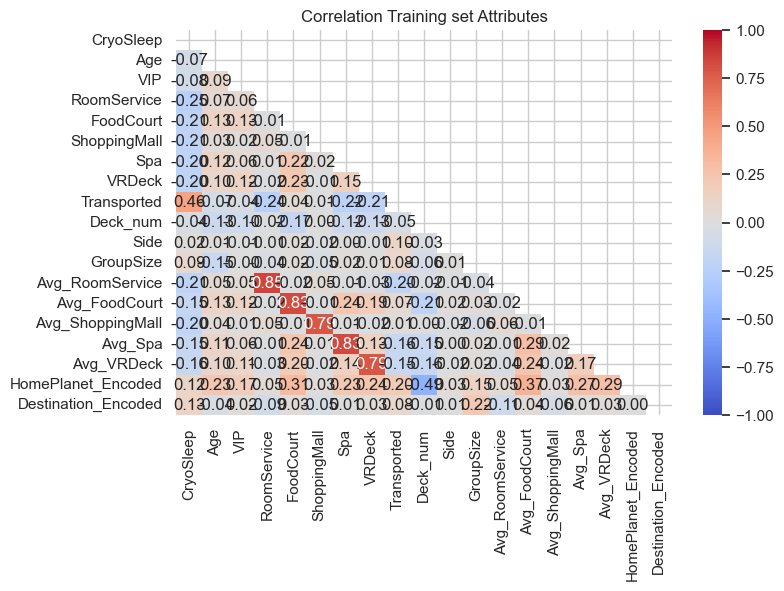

In [12]:
help_tool.heatmap(train, 'Training Set', 'pearson')

In [13]:
test = cleaning(test)
test.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck_num,Side,GroupSize,Avg_RoomService,Avg_FoodCourt,Avg_ShoppingMall,Avg_Spa,Avg_VRDeck,HomePlanet_Encoded,Destination_Encoded
0,0.0,18.0,0.0,736.0,40.0,0.0,0.0,0.0,817.0,1,1.0,736.0,40.0,0.0,0.000000,0.0,1,1.0
1,0.0,23.0,0.0,183.0,36.0,0.0,0.0,419.0,281.0,1,1.0,183.0,36.0,0.0,0.000000,419.0,1,2.0
2,0.0,25.0,0.0,599.0,0.0,1.0,0.0,0.0,383.0,0,1.0,599.0,0.0,1.0,0.000000,0.0,1,2.0
3,0.0,21.0,0.0,0.0,0.0,0.0,639.0,3.0,372.0,0,3.0,0.0,0.0,4.0,266.666667,246.0,1,1.0
4,0.0,24.0,0.0,0.0,0.0,12.0,161.0,735.0,372.0,0,3.0,0.0,0.0,4.0,266.666667,246.0,1,1.0


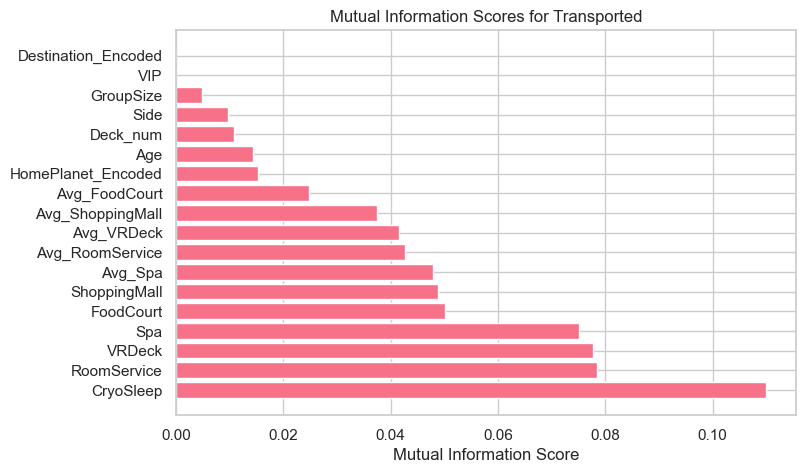

In [14]:
X = train.drop(['Transported'], axis=1)
y = train['Transported']

# Compute mutual information scores
mi_scores = pd.DataFrame(mutual_info_classif(
    X, y), index=X.columns, columns=['Mutual Information Gain'])
mi_scores.sort_values(by='Mutual Information Gain',
                      ascending=False, inplace=True)

# Visualize the scores
width = np.arange(len(mi_scores))
ticks = list(mi_scores.index)

plt.figure(dpi=100, figsize=(8, 5))
plt.barh(width, mi_scores['Mutual Information Gain'])
plt.yticks(width, ticks)
plt.xlabel("Mutual Information Score")
plt.title("Mutual Information Scores for Transported")
plt.show()

# Model

In [15]:
train['Transported'] = train['Transported'].astype(int)

In [16]:
train['Transported']

0       0
1       1
2       0
3       0
4       0
       ..
8688    1
8689    1
8690    1
8691    1
8692    1
Name: Transported, Length: 8693, dtype: int32

In [17]:
X = train.drop(['Transported']+avg_amenities, axis=1)
y = train['Transported']


(X_train, X_validation, y_train, y_validation) = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)


X_test = test


## Hyperparameted  tuning

In [18]:
models = {
    'Radial SVM': (SVC(probability=False), {
        'clf__C': [0.01, 10, 100, 1000], 
        'clf__gamma': [0.01, 10, 100, 1000]
        }),
    'Decision Tree': (DecisionTreeClassifier(), {
        'clf__criterion': ['gini', 'entropy'],
        'clf__max_depth': [None, 5, 10, 15, 20],
        'clf__min_samples_split': [2, 5, 10, 20, 50, 100],
        'clf__min_samples_leaf': [1, 2, 4]
    }),

    'Random Forest': (RandomForestClassifier(), {
        'clf__n_estimators': list(range(100, 1000, 10)), 
        'clf__max_depth': list(range(1, 110, 10)),
        'clf__max_features': ['sqrt', 'log2'],
        'clf__min_samples_split': [2, 5, 10], 
        'clf__min_samples_leaf': [1, 2, 4],  
        'clf__bootstrap': [True, False]
        }),

    'KNN': (KNeighborsClassifier(), {
        'clf__n_neighbors': list(range(2, 21)), 
        'clf__weights': ['uniform', 'distance'], 
        'clf__p': [1, 2],
        'clf__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
        }),

    'Naive Bayes': (GaussianNB(), {
            'clf__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
        }),

    'XGBoost': (XGBClassifier(), {
            'clf__max_depth': [3, 5, 7], 
            'clf__learning_rate': [0.1, 0.01], 
            'clf__n_estimators': [100, 200]
        })
}


# Loop over each model
for model_name, (model, param_dist) in models.items():
    pipeline = Pipeline([('scaler', StandardScaler()), ('clf', model)])

    random_search = RandomizedSearchCV(
        pipeline,  
        param_distributions=param_dist,
        n_iter=10,
        cv=10,
        random_state=42,
        scoring='accuracy' 
    )

    random_search.fit(X_train, y_train)

    best_clf = random_search.best_estimator_
    best_params = random_search.best_params_


    if model_name == 'Radial SVM':
        svm = best_clf
        svm_param = best_params
    elif model_name == 'Decision Tree':
        dtree = best_clf
        dtree_param = best_params
    elif model_name == 'Random Forest':
        rforest = best_clf
        rforest_param = best_params
    elif model_name == 'KNN':
        knn = best_clf
        knn_param = best_params
    elif model_name == 'Naive Bayes':
        nb = best_clf
        nb_param = best_params
    elif model_name == 'XGBoost':
        xgb = best_clf
        xgb_param = best_params


    print(f"Best Hyperparameters for {model_name}: {best_params}")


    accuracy_train = accuracy_score(y_train, best_clf.predict(X_train))
    accuracy_validation = accuracy_score(y_validation, best_clf.predict(X_validation))

    print(f"Validation Accuracy for {model_name}: {accuracy_train:.2f}/{accuracy_validation:.2f}")

c:\Users\Gintare\anaconda3\envs\dswh_env\Lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Hyperparameters for Dummy Classifier: {}
Validation Accuracy for Dummy Classifier: 0.50/0.50
Best Hyperparameters for Radial SVM: {'clf__gamma': 0.01, 'clf__C': 100}
Validation Accuracy for Radial SVM: 0.81/0.80
Best Hyperparameters for Decision Tree: {'clf__min_samples_split': 100, 'clf__min_samples_leaf': 1, 'clf__max_depth': 5, 'clf__criterion': 'entropy'}
Validation Accuracy for Decision Tree: 0.78/0.77
Best Hyperparameters for Random Forest: {'clf__n_estimators': 730, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 2, 'clf__max_features': 'log2', 'clf__max_depth': 41, 'clf__bootstrap': True}
Validation Accuracy for Random Forest: 0.96/0.80
Best Hyperparameters for KNN: {'clf__weights': 'uniform', 'clf__p': 1, 'clf__n_neighbors': 9, 'clf__algorithm': 'kd_tree'}
Validation Accuracy for KNN: 0.83/0.78


c:\Users\Gintare\anaconda3\envs\dswh_env\Lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Hyperparameters for Naive Bayes: {'clf__var_smoothing': 1e-09}
Validation Accuracy for Naive Bayes: 0.71/0.70
Best Hyperparameters for XGBoost: {'clf__n_estimators': 100, 'clf__max_depth': 3, 'clf__learning_rate': 0.1}
Validation Accuracy for XGBoost: 0.82/0.80


## Threshold tuning

In [49]:
def predict_proba_available(model, X_validation):
    # Check if predict_proba is available
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_validation)[:, 1]  # Get probabilities for positive class
    else:
        y_proba = model.predict(X_validation)  # Use predict for models without predict_proba

    return y_proba

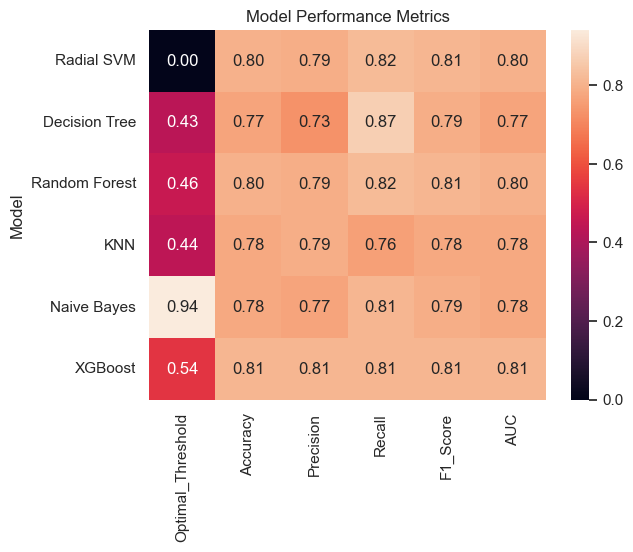

In [36]:
models = {
    # Baseline model
    #'dummy': {'model': DummyClassifier(strategy='uniform', random_state=1), 'label': 'Dummy'},
    'svm': {'model': svm, 'label': 'Radial SVM'},
    'dtree': {'model': dtree, 'label': 'Decision Tree'},
    'rforest': {'model': rforest, 'label': 'Random Forest'},
    'knn': {'model': knn, 'label': 'KNN'},
    'nb': {'model': nb, 'label': 'Naive Bayes'},
    'xgb': {'model': xgb, 'label': 'XGBoost'}
}



results = []

for name, model_info in models.items():
    model = model_info['model']
    label = model_info['label']

    # Create thresholds for decision threshold tuning
    thresholds = np.linspace(0, 1, 100)

    # Initialize variables to track best accuracy and threshold
    best_accuracy = 0
    optimal_threshold = 0

    # # Check if predict_proba is available
    # if hasattr(model, 'predict_proba'):
    #     y_proba = model.predict_proba(X_validation)[:, 1]  # Get probabilities for positive class
    # else:
    #     y_proba = model.predict(X_validation)  # Use predict for models without predict_proba
    y_proba = predict_proba_available(model, X_validation)

    # Find optimal threshold based on accuracy
    for threshold in thresholds:
        y_pred = (y_proba > threshold).astype(int)
        accuracy = accuracy_score(y_validation, y_pred)
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            optimal_threshold = threshold

    # Use the optimal threshold to predict final labels
    y_pred_optimal = (y_proba > optimal_threshold).astype(int)


    results.append({'Model': label,
                    'Optimal_Threshold': optimal_threshold,
                    'Accuracy': accuracy_score(y_validation, y_pred_optimal),
                    'Precision': precision_score(y_validation, y_pred_optimal),
                    'Recall': recall_score(y_validation, y_pred_optimal),
                    'F1_Score': f1_score(y_validation, y_pred_optimal),
                    'AUC': roc_auc_score(y_validation, y_pred_optimal)
                    })

model_threshol_search = pd.DataFrame(results)


sns.heatmap(model_threshol_search.set_index(
    'Model').round(2), annot=True, fmt=".2f")
plt.title('Model Performance Metrics')
plt.show()

In [38]:
thresholds_df = help_tool.feature_transpose(
    model_threshol_search, ['Model', 'Optimal_Threshold'])
thresholds_df

,Model,Radial SVM,Decision Tree,Random Forest,KNN,Naive Bayes,XGBoost
1,Optimal_Threshold,0.0,0.434343,0.464646,0.444444,0.939394,0.535354


# Cross Validation

In [50]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import pandas as pd

def cross_val_thresholds(fold, X, y, thresholds_df, classifiers):
    """ Cross validation with threshold adjustments and feature scaling """
    kf = KFold(n_splits=fold, shuffle=True, random_state=42)
    
    # Initialize lists to store metric scores and confusion matrices
    metric_scores = {metric: {clf_name: [] for clf_name in classifiers.keys()} 
                     for metric in ['accuracy', 'precision', 'recall', 'f1']}
    confusion_matrices = {clf_name: np.zeros((2, 2)) for clf_name in classifiers.keys()}
    
    for train_index, val_index in kf.split(X):
        X_train_i, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train_i, y_val = y.iloc[train_index], y.iloc[val_index]
        
        # Initialize and fit StandardScaler on training data
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_i)
        X_val_scaled = scaler.transform(X_val)
        
        for clf_name, clf in classifiers.items():
            clf.fit(X_train_scaled, y_train_i)
            
            # Threshold update
            # Assuming binary classification
             
            #scores = clf.predict_proba(X_val_scaled)[:, 1]
            scores = predict_proba_available(clf, X_val_scaled)

            optimal_threshold = thresholds_df[clf_name].iloc[0]
            y_pred = (scores > optimal_threshold).astype(int)
            
            # Calculate metrics
            metric_scores['accuracy'][clf_name].append(accuracy_score(y_val, y_pred))
            metric_scores['precision'][clf_name].append(precision_score(y_val, y_pred))
            metric_scores['recall'][clf_name].append(recall_score(y_val, y_pred))
            metric_scores['f1'][clf_name].append(f1_score(y_val, y_pred))
            
            # Compute confusion matrix
            cm = confusion_matrix(y_val, y_pred)
            confusion_matrices[clf_name] += cm
    
    # Calculate average scores
    avg_metric_scores = {metric: {clf_name: np.mean(scores) for clf_name, scores in clf_scores.items()} 
                         for metric, clf_scores in metric_scores.items()}
    
    # Average confusion matrices
    avg_confusion_matrices = {clf_name: matrix / fold for clf_name, matrix in confusion_matrices.items()}
    
    cv_results = []
    for clf_name, scores in avg_metric_scores['accuracy'].items():
        cv_results.append({
            'Classifier': classifiers[clf_name].__class__.__name__,
            'CV Mean Accuracy': np.mean(scores),
            'CV Mean Precision': np.mean(avg_metric_scores['precision'][clf_name]),
            'CV Mean Recall': np.mean(avg_metric_scores['recall'][clf_name]),
            'CV Mean F1': np.mean(avg_metric_scores['f1'][clf_name]),
            'Confusion Matrix': avg_confusion_matrices[clf_name]
        })
    
    model_info = pd.DataFrame(cv_results)
    return model_info


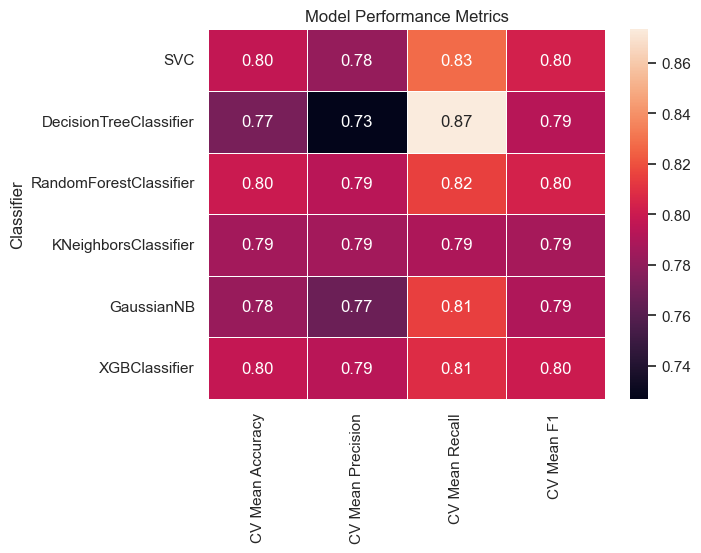

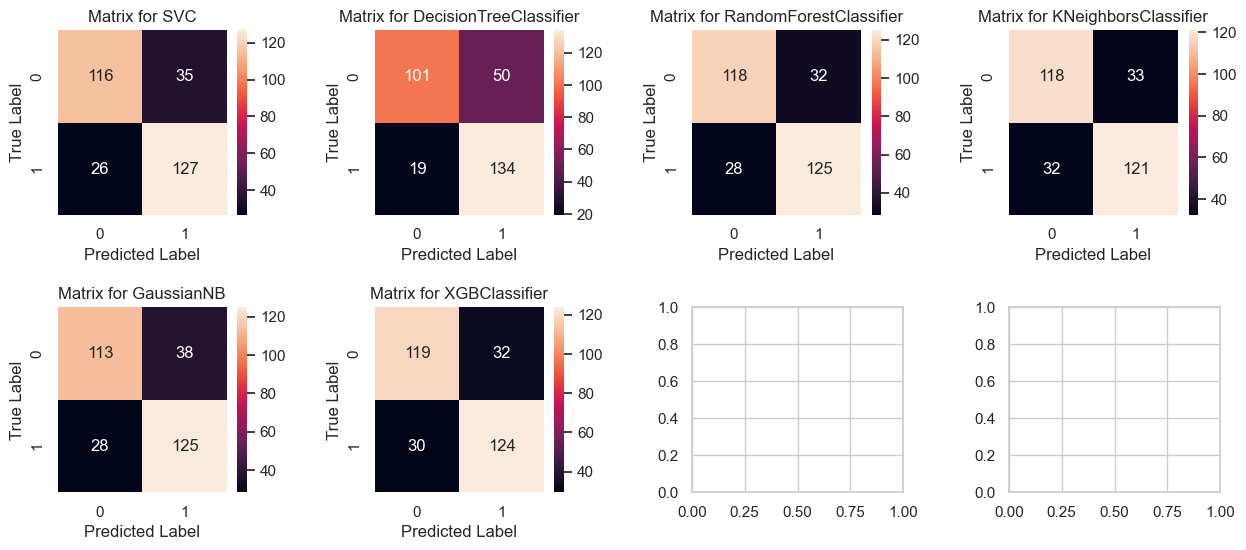

In [53]:
classifiers = {
    'Radial SVM': SVC(
        kernel='rbf', 
        probability=False, 
        C=svm_param['clf__C'], 
        gamma=svm_param['clf__gamma'], 
        random_state=42
    ),

    'Decision Tree': DecisionTreeClassifier(
        min_samples_split=dtree_param['clf__min_samples_split'],
        min_samples_leaf=dtree_param['clf__min_samples_leaf'],
        max_depth=dtree_param['clf__max_depth'],
        criterion=dtree_param['clf__criterion'], 
        random_state=42
    ),

    'Random Forest': RandomForestClassifier(
        n_estimators=rforest_param['clf__n_estimators'], 
        min_samples_split=rforest_param['clf__min_samples_split'], 
        min_samples_leaf=rforest_param['clf__min_samples_leaf'], 
        max_features=rforest_param['clf__max_features'], 
        max_depth=rforest_param['clf__max_depth'], 
        bootstrap=rforest_param['clf__bootstrap'], 
        random_state=42
    )
    ,
    'KNN': KNeighborsClassifier(
        weights=knn_param['clf__weights'], 
        p=knn_param['clf__p'], 
        n_neighbors=knn_param['clf__n_neighbors'],
        algorithm=knn_param['clf__algorithm']
    ),

    'Naive Bayes': GaussianNB(
        var_smoothing=nb_param['clf__var_smoothing']
    ),

    'XGBoost': XGBClassifier(
        max_depth=xgb_param['clf__max_depth'], 
        learning_rate=xgb_param['clf__learning_rate'], 
        n_estimators=xgb_param['clf__n_estimators'], 
        random_state=42
    )
}


def cross_val_plots(fold, X, y, thresholds_df, classifiers):

    model_info = cross_val_thresholds(
        fold, X, y, thresholds_df, classifiers)

    help_tool.cross_validation_param(
        model_info.drop('Confusion Matrix', axis=1))
    help_tool.cross_validation_confusion_matrix(model_info)


cross_val_plots(20, X_train, y_train, thresholds_df, classifiers)

# AdaBoost
SVM, Random Forest, XGB

In [64]:
classifiers_ADA = {
    'Radial SVM': SVC(
        kernel='rbf', 
        probability=False, 
        C=svm_param['clf__C'], 
        gamma=svm_param['clf__gamma'], 
        random_state=42
    ),

    'Random Forest': RandomForestClassifier(
        n_estimators=rforest_param['clf__n_estimators'], 
        min_samples_split=rforest_param['clf__min_samples_split'], 
        min_samples_leaf=rforest_param['clf__min_samples_leaf'], 
        max_features=rforest_param['clf__max_features'], 
        max_depth=rforest_param['clf__max_depth'], 
        bootstrap=rforest_param['clf__bootstrap'], 
        random_state=42
    ),


    'XGBoost': XGBClassifier(
        max_depth=xgb_param['clf__max_depth'], 
        learning_rate=xgb_param['clf__learning_rate'], 
        n_estimators=xgb_param['clf__n_estimators'], 
        random_state=42
    )
}

In [66]:
adaboost_classifiers = {}

for model_name, model in classifiers_ADA.items():
    adaboost_classifier = AdaBoostClassifier(
        estimator=model, n_estimators=50, algorithm='SAMME', random_state=42)
    
        # Initialize and fit StandardScaler on training data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_validation)

    adaboost_classifier.fit(X_train_scaled, y_train)
    adaboost_classifiers[model_name] = adaboost_classifier

for model_name, adaboost_classifier in adaboost_classifiers.items():
    # Calculate predictions
    predictions = predict_proba_available(adaboost_classifier, X_val_scaled)
    # if hasattr(adaboost_classifier, "predict_proba"):
    #     predictions = adaboost_classifier.predict_proba(X_validation)[:, 1]
    # else:
    #     predictions = adaboost_classifier.decision_function(X_validation)

    # Adjust decision threshold using the optimal threshold (assuming thresholds_df is defined)
    optimal_threshold = thresholds_df[model_name].iloc[0]
    adjusted_predictions = (predictions > optimal_threshold).astype(int)

    accuracy = accuracy(y_validation, adjusted_predictions)

    fpr, tpr, _ = roc_curve(y_validation, adjusted_predictions)
    roc_auc = auc(fpr, tpr)

    print(f"Model: {model_name}")
    print(f"Validation F1: {accuracy:.2%}")
    print(f"ROC AUC: {roc_auc:.2f}")

Model: Radial SVM
Validation F1: 66.97%
ROC AUC: 0.50
Model: Random Forest
Validation F1: 78.73%
ROC AUC: 0.79
Model: XGBoost
Validation F1: 66.97%
ROC AUC: 0.50


# Voting

In [78]:
thresholds_df['KNN']

,Model,Radial SVM,Decision Tree,Random Forest,KNN,Naive Bayes,XGBoost
1,Optimal_Threshold,0.0,0.434343,0.464646,0.444444,0.939394,0.535354


In [80]:
[sample]

['CryoSleep']

In [86]:
voting_clf_soft = VotingClassifier(estimators=[('knn', knn), ('rf', rforest), ('svm',  svm)], voting='hard')

pipeline = Pipeline([
    ('scaler', StandardScaler()),  
    ('voting_clf', voting_clf_soft)    
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('voting_clf',
                 VotingClassifier(estimators=[('knn',
                                               Pipeline(steps=[('scaler',
                                                                StandardScaler()),
                                                               ('clf',
                                                                KNeighborsClassifier(algorithm='kd_tree',
                                                                                     n_neighbors=9,
                                                                                     p=1))])),
                                              ('rf',
                                               Pipeline(steps=[('scaler',
                                                                StandardScaler()),
                                                               ('clf',
                                                                RandomForestClassifier(max_depth=41,
                                                                                       max_features='log2',
                                                                                       min_samples_leaf=2,
                                                                                       n_estimators=730))])),
                                              ('svm',
                                               Pipeline(steps=[('scaler',
                                                                StandardScaler()),
                                                               ('clf',
                                                                SVC(C=100,
                                                                    gamma=0.01))]))]))])

In [ ]:
predict_proba_available

In [94]:
y_pred_custom = []
for index, sample in X_validation.iterrows():
    knn_decision = knn.predict([sample])[0]
    svm_decision_value = svm.decision_function([sample])[0]  # Decision value from SVM
    rforest_decision_prob = rforest.predict_proba([sample])[0][1]  # Probability of class 1 from Random Forest
    
    # Access the threshold values
    knn_threshold = thresholds_df['KNN']
    svm_threshold = thresholds_df['Radial SVM']
    rforest_threshold = thresholds_df['Random Forest']
    
    # Apply thresholds
    knn_vote = 1 if knn_decision >= knn_threshold else 0
    svm_vote = 1 if svm_decision_value >= svm_threshold else 0
    rforest_vote = 1 if rforest_decision_prob >= rforest_threshold else 0
    
    # Aggregate votes (example: simple majority voting)
    final_vote = (knn_vote + svm_vote + rforest_vote) >= 2  # Threshold for majority voting
    
    y_pred_custom.append(final_vote)

# Evaluate accuracy of custom voting
accuracy_custom = accuracy_score(y_validation, y_pred_custom)
print(f'Accuracy with custom voting logic: {accuracy_custom:.4f}')

# Directly predict using the pipeline (using soft voting)
y_pred_pipeline = pipeline.predict(X_validation)

# Evaluate accuracy using pipeline prediction
accuracy_pipeline = accuracy_score(y_validation, y_pred_pipeline)
print(f'Accuracy with pipeline (soft voting): {accuracy_pipeline:.4f}')


c:\Users\Gintare\anaconda3\envs\dswh_env\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Gintare\anaconda3\envs\dswh_env\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Gintare\anaconda3\envs\dswh_env\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [89]:
# Make predictions on the validation set with custom decision rules
y_pred_custom = []
for index, sample in X_validation.iterrows():
    knn_decision = knn.predict([sample])[0]
    svm_decision_prob = svm.predict_proba([sample])[0][1]  # Probability of class 1 from SVM
    rforest_decision_prob = rforest.predict_proba([sample])[0][1]  # Probability of class 1 from Random Forest
    
    # Apply thresholds
    knn_vote = 1 if knn_decision >= thresholds_df['KNN'] else 0
    svm_vote = 1 if svm_decision_prob >= thresholds_df['Radial SVM'] else 0
    rforest_vote = 1 if rforest_decision_prob >= thresholds_df['Random Forest'] else 0
    
    # Aggregate votes (example: simple majority voting)
    final_vote = (knn_vote + svm_vote + rforest_vote) >= 2  # Threshold for majority voting
    
    y_pred_custom.append(final_vote)

# Evaluate accuracy of custom voting
accuracy_custom = accuracy_score(y_validation, y_pred_custom)
print(f'Accuracy with custom voting logic: {accuracy_custom:.4f}')

# Directly predict using the pipeline (using soft voting)
y_pred_pipeline = pipeline.predict(X_validation)

# Evaluate accuracy using pipeline prediction
accuracy_pipeline = accuracy_score(y_validation, y_pred_pipeline)
print(f'Accuracy with pipeline (soft voting): {accuracy_pipeline:.4f}')


c:\Users\Gintare\anaconda3\envs\dswh_env\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


AttributeError: predict_proba is not available when  probability=False

In [82]:
for i in X_validation:
    print(i)
    

CryoSleep
Age
VIP
RoomService
FoodCourt
ShoppingMall
Spa
VRDeck
Deck_num
Side
GroupSize
HomePlanet_Encoded
Destination_Encoded
